In [1]:
%matplotlib inline

import random
import shutil, os

path = "data\dogsvscats\\"

#### 1. After unpacking kaggle .zip, create a valid folder and move 2000 random samples from the train folder into it

In [34]:
if not os.path.exists(path+'valid'):
    files = os.listdir(path+'train')
    randoms = random.sample(range(len(files)), 2000)
    os.makedirs(path+'valid')
    for r in randoms:
        shutil.move(path+'train\\'+files[r], path+'valid\\'+files[r])

#### 2. Create a sample folder.
    1. Inside of your sample folder, create a train folder and copy 200 random samples to it from train.
    2. Again, inside of your sample folder, create a valid folder and copy 50 random samples to it from train.

In [35]:
if not os.path.exists(path+'sample'):
    os.makedirs(path+'sample')
    files = os.listdir(path+'train')
    randoms = random.sample(range(len(files)), 200)
    os.makedirs(path+'sample\\train')
    for r in randoms:
        shutil.copy(path+'train\\'+files[r], path+'sample\\train\\'+files[r])

    randoms = random.sample(range(len(files)), 50)
    os.makedirs(path+'sample\\valid')
    for r in randoms:
        shutil.copy(path+'train\\'+files[r], path+'sample\\valid\\'+files[r])

#### 3. For your valid, sample, and train folders:
    1. Create a cat folder and a dog folder
    2. Move all of your cat samples into the cat folder
    3. Move all of your dog samples into the dog folder

In [36]:
for folder in ['valid\\', 'sample\\valid\\', 'train\\','sample\\train\\']:
    if not os.path.exists(path+folder+'cat'):
        files = os.listdir(path+folder)
        os.makedirs(path+folder+'cat')
        os.makedirs(path+folder+'dog')
        for file in files:
            if 'cat' in file:
                shutil.move(path+folder+file, path+folder+'cat\\'+file)
            elif 'dog' in file:
                shutil.move(path+folder+file, path+folder+'dog\\'+file)

### Setup

In [2]:
from __future__ import division, print_function
import json
from glob import glob
import numpy as np
np.set_printoptions(precision=4, linewidth=100)
os.environ["CUDA_DEVICE_ORDER"]='PCI_BUS_ID'
os.environ["CUDA_VISIBLE_DEVICES"]='3'
path = 'data\dogsvscats\\'

In [3]:
from matplotlib import pyplot as plt
from importlib import reload
import utils; reload(utils)
from utils import plots

Using TensorFlow backend.


In [4]:
batch_size = 32
import vgg16; reload(vgg16)
from vgg16 import Vgg16

### Model creation and tuning

In [5]:
vgg = Vgg16()
train_batches = vgg.get_batches(path+'train', batch_size=batch_size)
val_batches = vgg.get_batches(path+'valid', batch_size=batch_size*2)
vgg.finetune(train_batches)

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [6]:
vgg.model.load_weights('data\\dogsvscats\\results\\ft1.h5') #load previous weights if required

### Fitting and saving

In [22]:
vgg.model.optimizer.lr = 0.01 #use once accuracy stagnates over multiple epochs
vgg.fit(train_batches, val_batches, nb_epoch=1)

Epoch 1/1
23000/23000 [==============================] - 382s - loss: 0.4953 - acc: 0.8718 - val_loss: 0.3777 - val_acc: 0.8915


In [7]:
vgg.model.save_weights('data\\dogsvscats\\results\\ft1.h5') #save weights if required

### Visualise results

In [8]:
vis_batch_size = 64
vis_batches = vgg.get_batches(path+'valid', batch_size=vis_batch_size,shuffle=True)
no_vis_batches = 4
img, val_labels = next(vis_batches)
for i in range(no_vis_batches-1):
    img1, val_labels1 = next(vis_batches)
    img = np.append(img, img1, 0)
    val_labels = np.append(val_labels, val_labels1, 0)
val_labels = val_labels[:,1]

Found 2000 images belonging to 2 classes.


In [9]:
preds = vgg.model.predict_generator(vis_batches,no_vis_batches*vis_batch_size)[:,1]

In [10]:
img.shape, val_labels.shape, preds.shape

((256, 224, 224, 3), (256,), (256,))

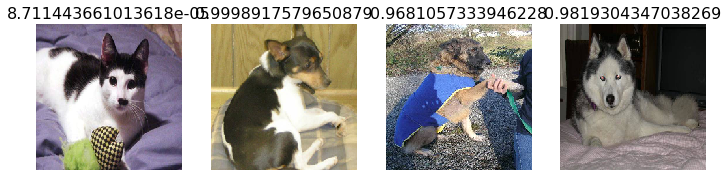

In [11]:
#1. A few correct labels at random
correct = np.where(np.rint(preds)==val_labels)[0]
idx = np.random.choice(correct, 4).tolist()
plots(img[idx,:,:], titles=preds[idx].tolist())

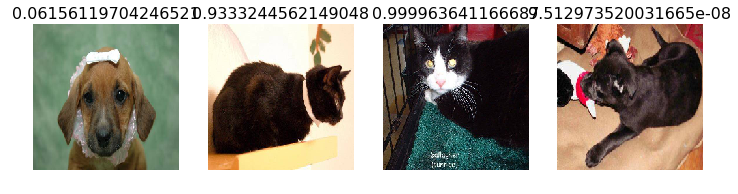

In [12]:
#2. A few incorrect labels at random
incorrect = np.where(np.rint(preds)!=val_labels)[0]
idx = np.random.choice(incorrect, 4).tolist()
plots(img[idx,:,:], titles=preds[idx].tolist())

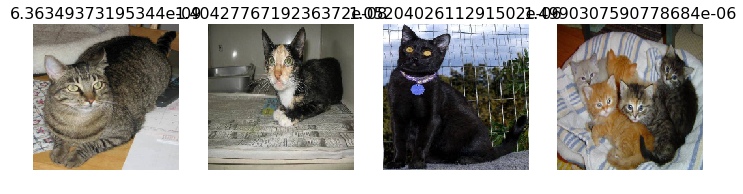

In [13]:
#3. The images we most confident were cats, and are actually cats
correct_cats = np.where((np.rint(preds)==0) & (np.rint(preds)==val_labels))[0]
most_correct_cats = correct_cats[np.argsort(preds[correct_cats])][:4]
plots(img[most_correct_cats,:,:], titles=preds[most_correct_cats].tolist())

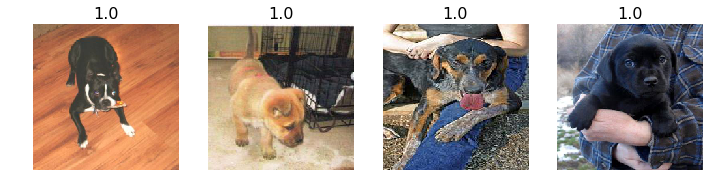

In [14]:
#4. as above, but dogs
correct_dogs = np.where((np.rint(preds)==1) & (np.rint(preds)==val_labels))[0]
most_correct_dogs = correct_dogs[np.argsort(preds[correct_dogs])][-4:]
plots(img[most_correct_dogs,:,:], titles=preds[most_correct_dogs].tolist())

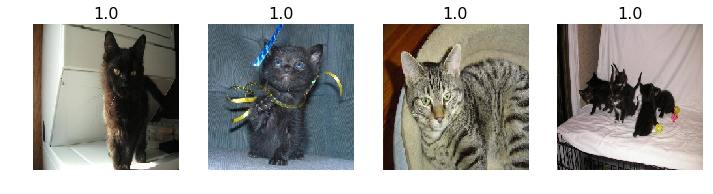

In [15]:
#5. The images we were most confident were dogs, but are actually cats
incorrect_dogs = np.where((np.rint(preds)==1) & (np.rint(preds)!=val_labels))[0]
most_incorrect_dogs = incorrect_dogs[np.argsort(preds[incorrect_dogs])][-4:]
plots(img[most_incorrect_dogs,:,:], titles=preds[most_incorrect_dogs].tolist())

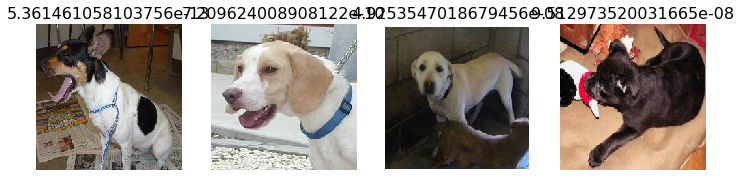

In [16]:
#6. The images we were most confident were cats, but are actually dogs
incorrect_cats = np.where((np.rint(preds)==0) & (np.rint(preds)!=val_labels))[0]
most_incorrect_cats = incorrect_cats[np.argsort(preds[incorrect_cats])][:4]
plots(img[most_incorrect_cats,:,:], titles=preds[most_incorrect_cats].tolist())

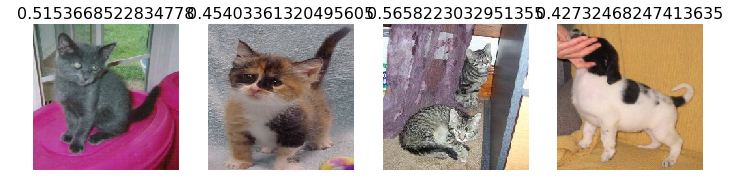

In [17]:
#7. The most uncertain labels (ie those with probability closest to 0.5).
most_uncertain = np.argsort(np.abs(preds-0.5))[:4]
plots(img[most_uncertain,:,:], titles=preds[most_uncertain].tolist())

Confusion matrix, without normalization
[[55 57]
 [60 84]]


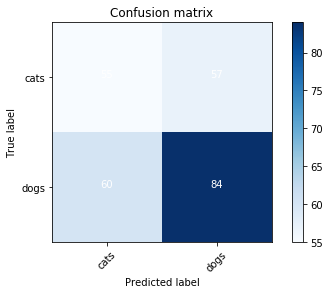

In [18]:
from sklearn.metrics import confusion_matrix
import itertools
cm = confusion_matrix(val_labels,np.rint(preds))

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plot_confusion_matrix(cm, ['cats','dogs'])

### Run model on test files and export result

In [23]:
from keras import preprocessing
datagen = preprocessing.image.ImageDataGenerator()
generator = datagen.flow_from_directory(
    path+'test\\',
    target_size=(224, 224),
    batch_size=16,
    class_mode=None,
    shuffle=False)

Found 12500 images belonging to 1 classes.


In [24]:
ntests = len(os.listdir(path+'test\\test\\'))
preds = vgg.model.predict_generator(generator, ntests)[:,1] #get keep probability of dog only

In [25]:
import csv
with open(path+'results.csv', 'w') as csvfile:
    csvfile.truncate()
    csvfile.write('id,label')
    for id in range(ntests):
        csvfile.write('\n')
        csvfile.write(str(id+1)+','+str(np.clip(preds[id], 0.05, 0.95))) #clip output to stop log loss function blowing up

from PIL import Image

def img_generator(path, batchsize=64):
    files = os.listdir(path)
    batches = np.array_split(np.array(np.array(files)), -(-len(files)//batchsize))
    for batch in batches:
        yield np.array([np.array(Image.open(path+file)) for file in batch])

mygenerator = img_generator(path+'test\\')

imgs2=next(mygenerator)

vgg.model.predict_generator(mygenerator,64)